In [1]:
from matplotlib import pyplot as plt
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
from utils import read_gbench, read_gset
from args import my_get_args
from simcim import SIMCIM
import itertools
import torch
import json
from scipy.signal import savgol_filter

In [2]:
gbench = read_gbench('./data/gbench.txt')

In [3]:
ind = [0, 100, 200, 500]

agent_data = []

for g in range(1,11):
    for s in [1,2,3]:
        with open('checkpoints/ppo/ref-G{}-seed{}.res'.format(g, s)) as f:
            res = json.load(f)
        mx = np.array(res['train_max'])[ind].T/res['bls_bench']
        md = np.array(res['train_median'])[ind].T/res['bls_bench']
        solved = (mx >= 1).astype(float)
        agent_data.append(np.vstack([mx,md,solved]))

agent_data = np.mean(agent_data, axis=0)

In [4]:
agent_data

array([[0.99901538, 0.99959747, 0.99973805, 0.99975526],
       [0.99008277, 0.9900895 , 0.99252138, 0.99788514],
       [0.13333333, 0.6       , 0.73333333, 0.8       ]])

In [5]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
def tanh_pump(O,S,D,Jmax,amin=0,amax=-1,N=1000):
    i = torch.arange(N,dtype=torch.float32)
    arg = torch.tensor(S,dtype = torch.float32)*(i/N-0.5)
    ret = (Jmax*O*(torch.tanh(arg).numpy() + D) + amin)/(amin-amax)
    return lambda i: float(ret[i])

In [6]:
args = my_get_args('')

config = dict(
    sigma = args.sim_sigma,
    momentum = args.sim_momentum
)
config_tanh = dict(
    sigma = 0.3,
    momentum = 0.9
)
batch_size = 256

comp_data = []

for g in range(1,11):
    for seed in range(30):
        set_seed(seed)
        gr = read_gset('../data/G{}.txt'.format(g), negate=True)
        sim = SIMCIM(gr, device='cuda', batch_size=batch_size, **config)
        sim.runpump()
        mx = np.max(sim.lastcuts) / gbench[g]
        md = np.median(sim.lastcuts) / gbench[g]
        solved = float(mx >= 1)
        d1 = np.array([[mx,md,solved]]).T
        
        sim = SIMCIM(gr, device='cuda', batch_size=batch_size, **config_tanh)
        sim.lr = 0.3
        J = torch.max(torch.sum(torch.abs(torch.tensor(gr)),1)).item()
        tpump = tanh_pump(0.1, 2, -0.9, J, sim.mie, sim.me)
        sim.runpump(pumpfunc=tpump)
        mx = np.max(sim.lastcuts) / gbench[g]
        md = np.median(sim.lastcuts) / gbench[g]
        solved = float(mx >= 1)
        d2 = np.array([[mx,md,solved]]).T
        
        d = np.hstack([d1,d2])
        comp_data.append(d)
    
comp_data = np.mean(comp_data, axis=0)

In [7]:
comp_data

array([[0.99917638, 0.99964042],
       [0.99418282, 0.99473178],
       [0.24666667, 0.66      ]])

In [8]:
data = pd.DataFrame(data=np.hstack([comp_data, agent_data]), 
                    index = ['Maximum', 'Median', 'Solved'],
                    columns=['Linear', 'Manual'] + ['Agent-{}'.format(i) for i in ind])
data.loc['Maximum'] = ['{:.4f}'.format(e) for e in data.loc['Maximum'].values]
data.loc['Median']  = ['{:.4f}'.format(e) for e in data.loc['Median'].values]
data.loc['Solved']  = ['{:.2f}'.format(e) for e in data.loc['Solved'].values]

data

,Linear,Manual,Agent-0,Agent-100,Agent-200,Agent-500
Maximum,0.9992,0.9996,0.9990,0.9996,0.9997,0.9998
Median,0.9942,0.9947,0.9901,0.9901,0.9925,0.9979
Solved,0.25,0.66,0.13,0.60,0.73,0.80


In [9]:
print(data.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &  Linear &  Manual & Agent-0 & Agent-100 & Agent-200 & Agent-500 \\
\midrule
Maximum &  0.9992 &  0.9996 &  0.9990 &    0.9996 &    0.9997 &    0.9998 \\
Median  &  0.9942 &  0.9947 &  0.9901 &    0.9901 &    0.9925 &    0.9979 \\
Solved  &    0.25 &    0.66 &    0.13 &      0.60 &      0.73 &      0.80 \\
\bottomrule
\end{tabular}



In [53]:
options = ['ref-G{}', 'nofilm-G{}', 'R2-G{}', 
           'scratch-G{}', 'nofilm-scratch-G{}', 'R2-scratch-G{}']
names = itertools.product(['Transfer', 'From scratch'], ['R3', 'R3, no FILM', 'R2'])

index = [100, 200, 500]

data = []

for g in range(1,11):
    for s in [1,2,3]:
        d = []
        for opt in options:
            fn = 'checkpoints/ppo/'+opt.format(g)+'-seed{}.res'.format(s)
            with open(fn) as f:
                res = json.load(f)
            mx = np.array(res['train_max'])[index] / res['bls_bench'][0]
            sl = (mx >= 1.).astype(float)
            d.append(sl)
        data.append(np.hstack(d))
        
data = np.mean(data, axis=0)
data = [['{:.2f}'.format(u) for u in e] for e in data]
data = pd.DataFrame(data=data, 
                    columns=pd.MultiIndex.from_tuples(names), 
                    index=['Solved ({} it.)'.format(i) for i in index])

In [54]:
data

Transfer                   From scratch                  
                       R3 R3, no FILM    R2           R3 R3, no FILM    R2
Solved (100 it.)     0.60        0.63  0.60         0.40        0.37  0.10
Solved (200 it.)     0.73        0.70  0.67         0.47        0.53  0.33
Solved (500 it.)     0.80        0.77  0.70         0.73        0.73  0.53

In [55]:
print(data.to_latex(multicolumn=False))

\begin{tabular}{lllllll}
\toprule
{} & Transfer &             &       & From scratch &             &       \\
{} &       R3 & R3, no FILM &    R2 &           R3 & R3, no FILM &    R2 \\
\midrule
Solved (100 it.) &     0.60 &        0.63 &  0.60 &         0.40 &        0.37 &  0.10 \\
Solved (200 it.) &     0.73 &        0.70 &  0.67 &         0.47 &        0.53 &  0.33 \\
Solved (500 it.) &     0.80 &        0.77 &  0.70 &         0.73 &        0.73 &  0.53 \\
\bottomrule
\end{tabular}



In [22]:
options = ['ref-G{}', 'nofilm-G{}', 'R2-G{}', 
           'scratch-G{}', 'nofilm-scratch-G{}', 'R2-scratch-G{}']
names = list(itertools.product(['Transfer', 'From scratch'], ['R3', 'R3, no FILM', 'R2']))

colors = ['g', 'y', 'r', 'b--', 'c--', 'm--']

data = []

for g in range(1,11):
    for s in [1,2,3]:
        d = []
        for opt in options:
            fn = 'checkpoints/ppo/'+opt.format(g)+'-seed{}.res'.format(s)
            with open(fn) as f:
                res = json.load(f)
            mx = np.array(res['train_max']) / res['bls_bench'][0]
            sl = (mx >= 1.).astype(float)
            d.append(sl)
            #d.append(mx)
        data.append(np.hstack(d))
    
mean = np.mean(data, axis=0)
std =  np.std(data, axis=0)

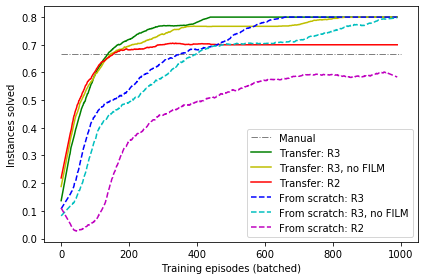

In [23]:
plt.plot([0,1000], [0.666, 0.666], 'gray', label='Manual', ls='-.', lw=1)
for m,s,l,c in zip(mean.T, std.T, names, colors):
    m = savgol_filter(m, 51, 1)
    s = savgol_filter(s, 51, 1)
    plt.plot(m, c, label=': '.join(l))
    #plt.fill_between(np.arange(m.size), m - s/10, m + s/10, color=c, alpha=0.2)
plt.legend()
#plt.ylim(0.999)
#plt.title('Ablation study: fraction of solved instances')
plt.ylabel('Instances solved')
plt.xlabel('Training episodes (batched)')
plt.tight_layout()
plt.savefig('plots_paper/ablation.pdf')
plt.show()

In [57]:
data = []

options = ['ref-G{}-seed{}.res', 'R2-G{}-seed{}.res', 'scratch-G{}-seed{}.res', 'R2-scratch-G{}-seed{}.res']
names = list(itertools.product(['Transfer', 'From scratch'], ['R3', 'R2']))
colors = ['g', 'r', 'b--', 'm--']
graph = 2

data = []
for s in [1,2,3]:
    d = []
    for opt in options:
        with open('checkpoints/ppo/'+opt.format(graph, s)) as f:
            res = json.load(f)
        baseline = res['bls_bench'][0]
        perc = np.array(res['train_percentiles']) + baseline
        #perc = np.array(res['train_max'])
        d.append(perc)
    data.append(np.hstack(d))
data = np.mean(data, axis=0)

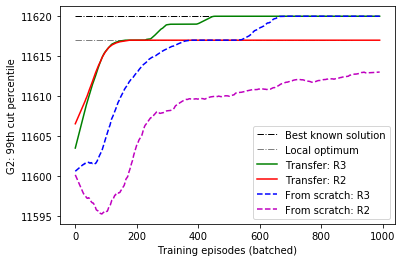

In [58]:
plt.plot([0,900],[baseline,baseline], 'black', ls='-.', lw=1, label='Best known solution')
plt.plot([0,900],[baseline-3,baseline-3], 'gray', ls='-.', lw=1,  label='Local optimum')
for d,l,c in zip(data.T, names, colors):
    d = savgol_filter(d, 51, 1)
    plt.plot(d, c, label=': '.join(l))
plt.ylabel('G2: 99th cut percentile')
plt.xlabel('Training episodes (batched)')
plt.legend()
plt.savefig('plots_paper/g2.pdf')
plt.show()

In [59]:
args = my_get_args('')
config = dict(
    sigma = args.sim_sigma,
    momentum = args.sim_momentum
)
batch_size = 256

data = []
g = 2

for seed in range(3):
    set_seed(seed)
    gr = read_gset('../data/G{}.txt'.format(g), negate=True)
    sim = SIMCIM(gr, device='cuda', batch_size=batch_size, **config)

    J = torch.max(torch.sum(torch.abs(torch.tensor(gr)),1)).item()
    tpump = tanh_pump(0.1, 2, -0.9, J, sim.mie, sim.me)
    sim.runpump(pumpfunc=tpump)
    md = np.median(sim.lastcuts)

    data.append(md)
    
median = np.mean(data)
median

11593.667

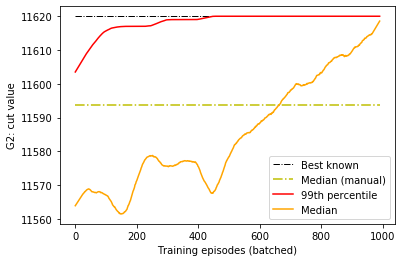

In [68]:
perc = []
med = []

for s in [1,2,3]:
    with open('checkpoints/ppo/ref-G{}-seed{}.res'.format(graph, s)) as f:
        res = json.load(f)
    perc.append(res['train_percentiles'])
    med.append(res['train_median'])
perc = np.mean(perc, axis=0)
med = np.mean(med, axis=0)
baseline = res['bls_bench'][0]

plt.plot([0,900],[baseline,baseline], 'black', ls='-.', lw=1, label='Best known')
plt.plot([0,990],[median,median], 'y', ls='-.', label='Median (manual)')
mx = perc.ravel() + baseline
md = med.ravel()
mx = savgol_filter(mx, 51, 1)
md = savgol_filter(md, 51, 1)
plt.plot(mx, 'r', label='99th percentile')
plt.plot(md, 'orange', label='Median')
plt.ylabel('G2: cut value')
plt.xlabel('Training episodes (batched)')
plt.legend()

plt.savefig('plots_paper/median.pdf')

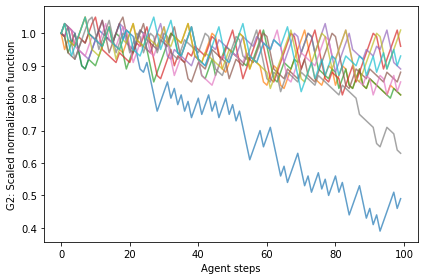

In [75]:
plt.plot(res['spumps'], alpha=0.7)
plt.ylabel('G2: Scaled normalization function')
plt.xlabel('Agent steps')
plt.tight_layout()
plt.savefig('plots_paper/pumps.pdf')
plt.show()

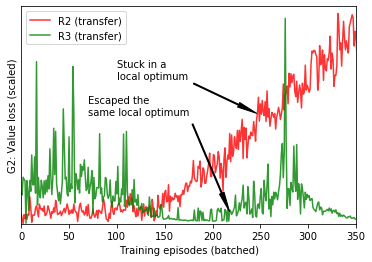

In [146]:
with open('checkpoints/ppo/ref-G2-seed3.res') as f:
    res = json.load(f)
with open('checkpoints/ppo/R2-G2-seed3.res') as f:
    res1 = json.load(f)

fig, ax = plt.subplots()
plt.plot(np.array(res1['vlosses'])/12, 'r', label='R2 (transfer)', alpha=0.8)
plt.plot(res['vlosses'], 'g', label='R3 (transfer)', alpha=0.8)
plt.xlim(0,350)
plt.yticks([],[])
plt.ylabel('G2: Value loss (scaled)')
plt.xlabel('Training episodes (batched)')
plt.ylim(0, 0.003)
ax.annotate('Stuck in a\nlocal optimum', xy=(250,0.0015), xytext=(100, 0.002),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=20),
            )
ax.annotate('Escaped the\nsame local optimum', xy=(220,0.0001), xytext=(70, 0.0015),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5, headlength=20),
            )
plt.legend()
plt.savefig('plots_paper/loss.pdf')
plt.show()

In [148]:
delta = np.array([0]*8 + [-4, -1])
bls = np.array([gbench[i] for i in range(1,11)])
agent = bls + delta

data = np.vstack([bls, agent, delta])

In [161]:
agent = []
bls = []

for g in range(1,11):
    with open('checkpoints/ppo/ref-G{}-seed3.res'.format(g)) as f:
        res = json.load(f)
    agent.append(res['train_max'][-1][0])
    bls.append(res['bls_bench'][0])
    
agent = np.array(agent)
bls = np.array(bls)
data = np.vstack([bls, agent, agent-bls]).astype(int)
data = pd.DataFrame(data, columns=['G'+str(g) for g in range(1,11)], index=['BLS \\cite{bls}', 'Agent', 'delta'])

In [164]:
print(data.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &     G1 &     G2 &     G3 &     G4 &     G5 &    G6 &    G7 &    G8 &    G9 &   G10 \\
\midrule
BLS \textbackslash cite\{bls\} &  11624 &  11620 &  11622 &  11646 &  11631 &  2178 &  2006 &  2005 &  2054 &  2000 \\
Agent          &  11624 &  11620 &  11622 &  11646 &  11631 &  2178 &  2006 &  2005 &  2050 &  1999 \\
delta          &      0 &      0 &      0 &      0 &      0 &     0 &     0 &     0 &    -4 &    -1 \\
\bottomrule
\end{tabular}

